### Imports

In [101]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
from tqdm import tqdm
import logging
from PIL import Image
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")

###  Dataset

In [79]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

In [80]:
data_dir='dataset/train'
dataset = PlayingCardDataset(data_dir=data_dir)

In [72]:
len(dataset)

7624

In [73]:
dataset[6000]

(<PIL.Image.Image image mode=RGB size=224x224>, 41)

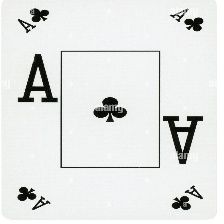

In [13]:
image, label = dataset[10]
image

In [15]:
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [75]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = PlayingCardDataset(data_dir=data_dir, transform=transform)

In [76]:
image, label = dataset[10]
image.shape

torch.Size([3, 128, 128])

In [120]:
image

tensor([[[0.9961, 0.9765, 0.9373,  ..., 1.0000, 1.0000, 1.0000],
         [0.9961, 0.9490, 0.9294,  ..., 1.0000, 1.0000, 0.9961],
         [0.9843, 0.9451, 0.9333,  ..., 1.0000, 0.9961, 1.0000],
         ...,
         [1.0000, 1.0000, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         [0.9961, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 0.9961,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.9961, 0.9765, 0.9373,  ..., 1.0000, 1.0000, 1.0000],
         [0.9961, 0.9490, 0.9294,  ..., 1.0000, 1.0000, 0.9961],
         [0.9843, 0.9451, 0.9333,  ..., 1.0000, 0.9961, 1.0000],
         ...,
         [1.0000, 1.0000, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         [0.9961, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 0.9961,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.9961, 0.9686, 0.9294,  ..., 1.0000, 1.0000, 1.0000],
         [0.9922, 0.9412, 0.9216,  ..., 1.0000, 1.0000, 0.9961],
         [0.9804, 0.9412, 0.9255,  ..., 1.0000, 0.9961, 1.

In [30]:
for image, label in dataset:
    break

### Dataloaders PyTorch
- Batching our dataset

In [60]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [35]:
for images, labels in dataloader:
    break

In [36]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

### PyTorch Model

In [113]:
class SimpleCardClassifier(nn.Module):
    def __init__(self, num_classes=53):
        # Here we define all the parts of the model
        super(SimpleCardClassifier, self).__init__()
        self.base_model = timm.create_model("efficientnet_b0", pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
            # About the line above -> Remove the classification head of a pre-trained model to use it as a feature extractor.
            # Help Fine-tune a model by replacing the final layer(s) with custom layers.
        enet_out_size = 1280 # Efficient net output size
        # Make a classifier
        self.flatten = nn.Flatten(1)
        self.classifier = nn.Linear(enet_out_size, num_classes)

    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        #x = nn.Flatten(x.view(x.size(0), -1))
        x = self.flatten(x)
        output = self.classifier(x)
        return output

In [56]:
device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")
model = SimpleCardClassifier(num_classes=53).to(device)

In [58]:
example_output = model(images.to(device)) #images created a few cells above
example_output.shape # [batch_size, num_classes]

torch.Size([32, 53])

### Training Loop

In [85]:
# Loss function
criterion = nn.CrossEntropyLoss().to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [88]:
criterion(example_output, labels.to(device))

tensor(3.9915, device='mps:0', grad_fn=<NllLossBackward0>)

In [89]:
train_folder = 'dataset/train'
valid_folder = 'dataset/valid'
test_folder = 'dataset/test'

train_dataset = PlayingCardDataset(train_folder, transform=transform)
valid_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [92]:
import logging

In [115]:
num_epochs = 5
train_losses, val_losses = [], []

model = SimpleCardClassifier(num_classes=53).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):

    # Training phase
    model.train()
    running_loss = 0.0
    logging.info(f"Epoch #{epoch + 1} out of {num_epochs} started")
    for images, labels in tqdm(train_loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    running_loss = 0.0
    for images, labels in tqdm(valid_loader, desc='Validation'):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(valid_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")
    #logging.info(f"Epoch #{epoch+1} completed.")

Validation: 100%|██████████| 9/9 [00:00<00:00, 31.76it/s]


Epoch 1/5 - Train loss: 1.5841071636641764, Validation loss: 0.31670185170083676


Validation: 100%|██████████| 9/9 [00:00<00:00, 32.89it/s]


Epoch 2/5 - Train loss: 0.5727240373805588, Validation loss: 0.2142317127506688


Validation: 100%|██████████| 9/9 [00:00<00:00, 32.95it/s]


Epoch 3/5 - Train loss: 0.34507198148609336, Validation loss: 0.19583525567684534


Validation: 100%|██████████| 9/9 [00:00<00:00, 31.34it/s]


Epoch 4/5 - Train loss: 0.24769078551597135, Validation loss: 0.11514933221745041


Validation: 100%|██████████| 9/9 [00:00<00:00, 29.03it/s]

Epoch 5/5 - Train loss: 0.18369268757317525, Validation loss: 0.28567795674755886


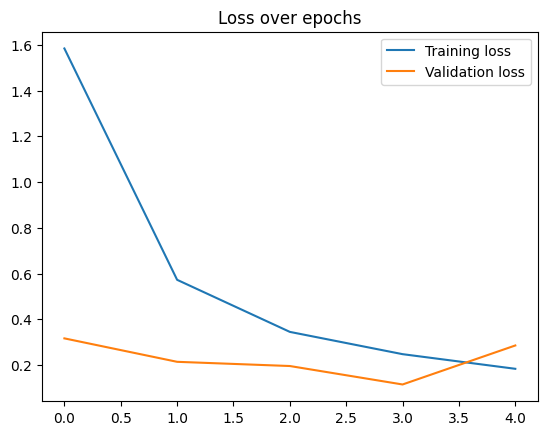

In [116]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

### Bonus: Evaluating the Results

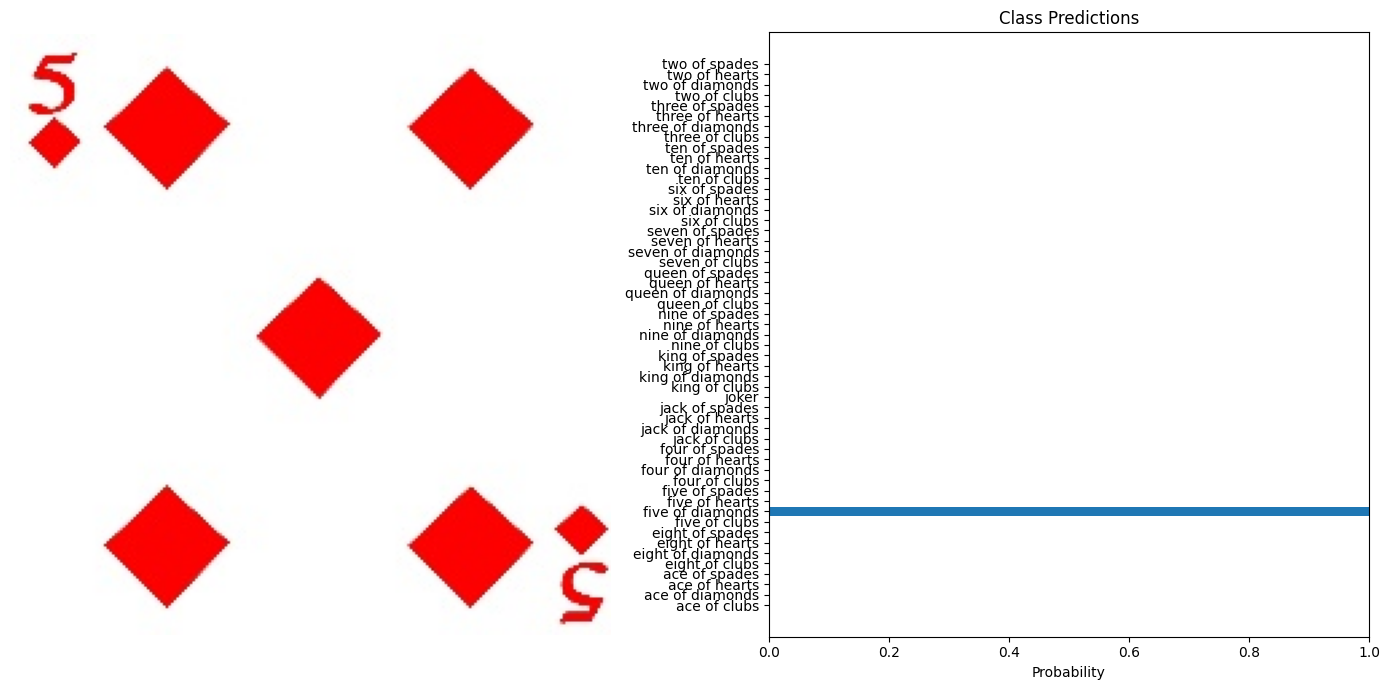

In [118]:
# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))

    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")

    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "dataset/test/five of diamonds/2.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes
visualize_predictions(original_image, probabilities, class_names)

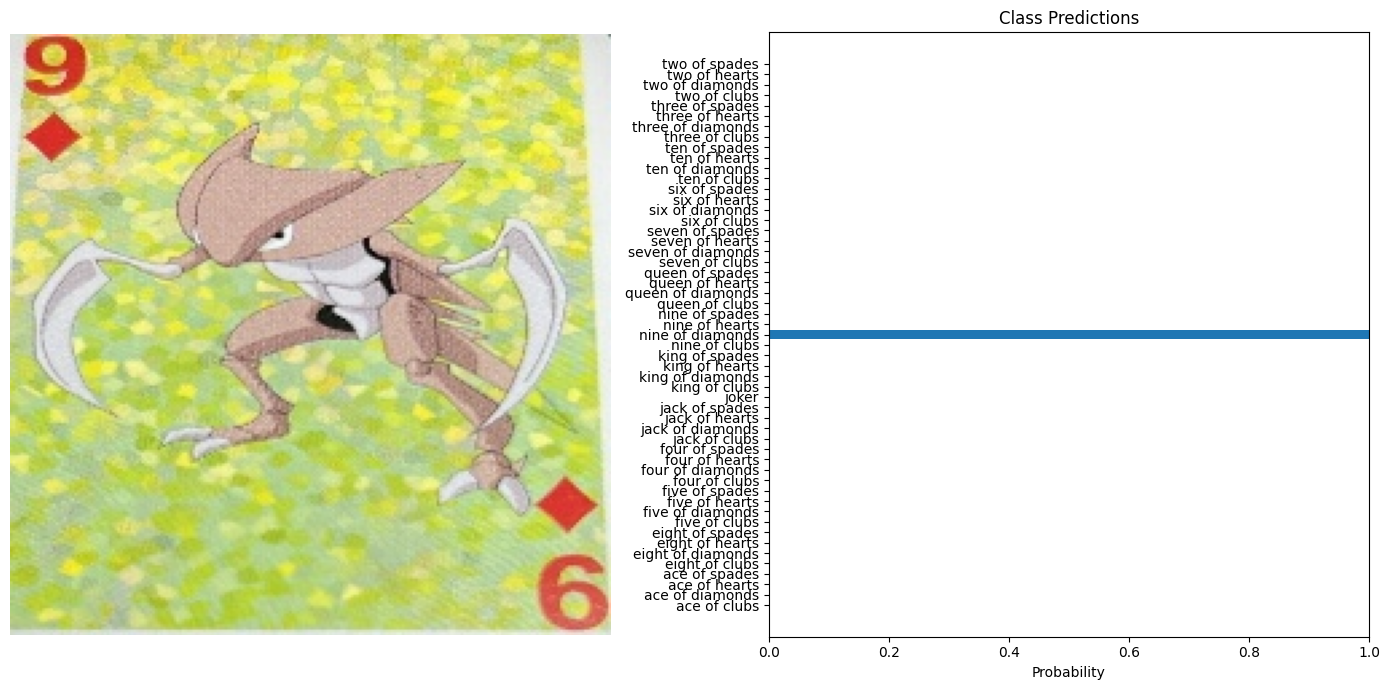

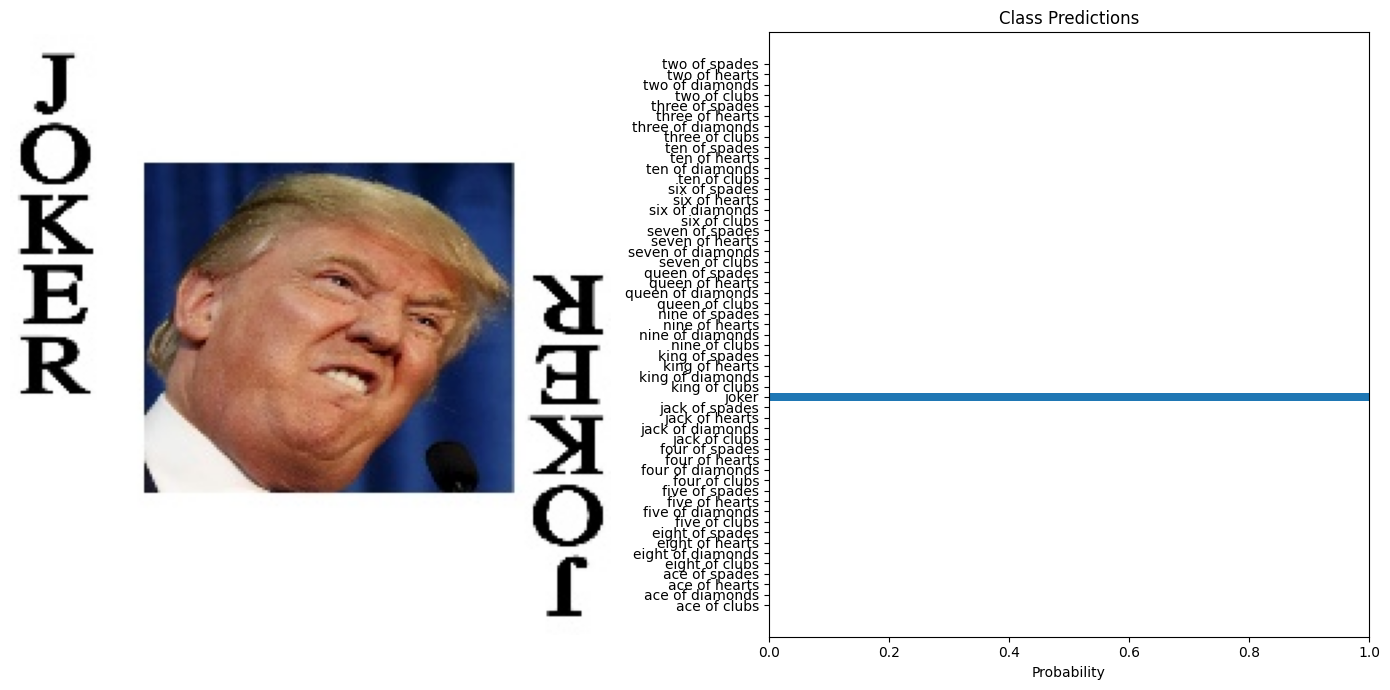

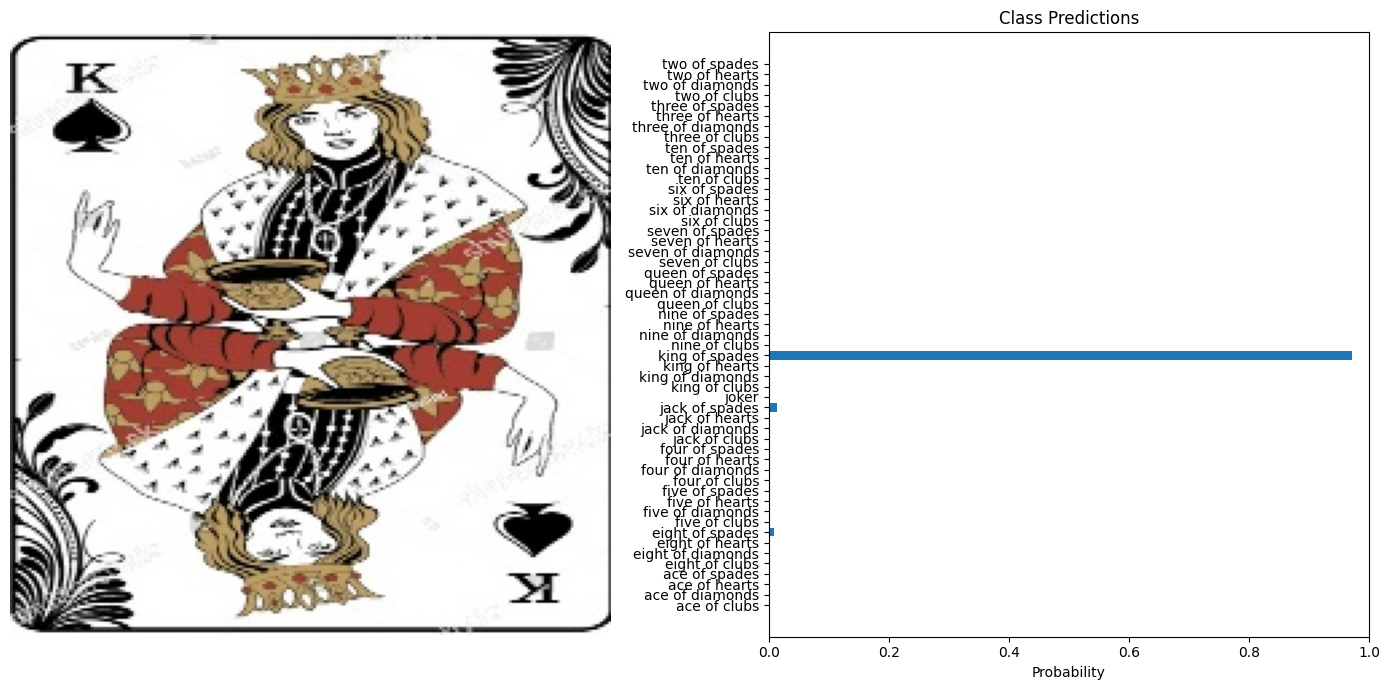

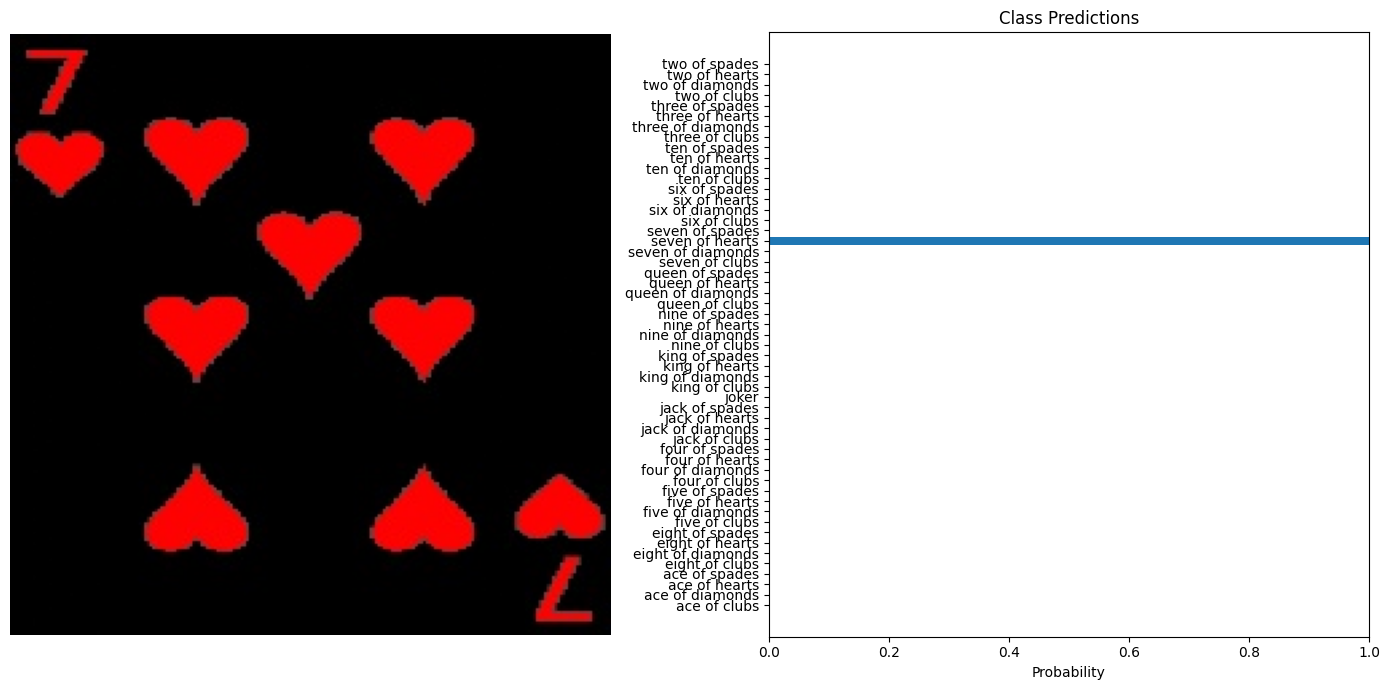

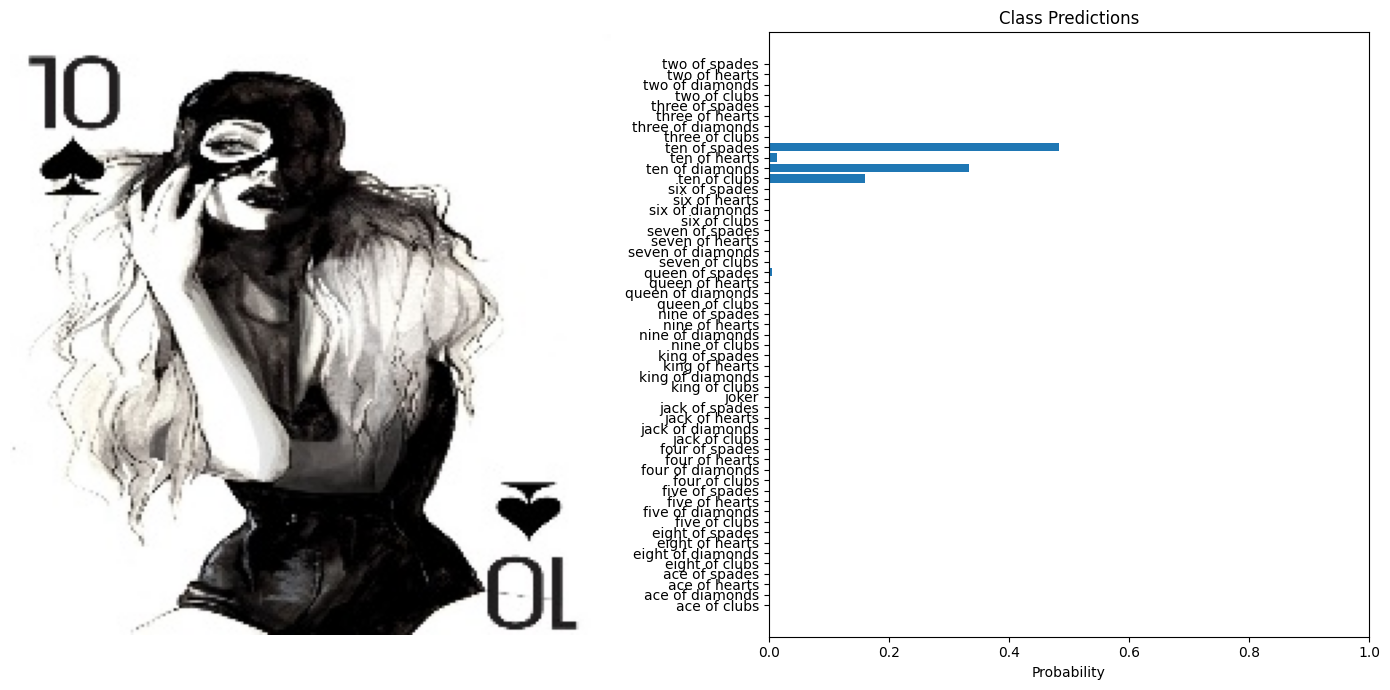

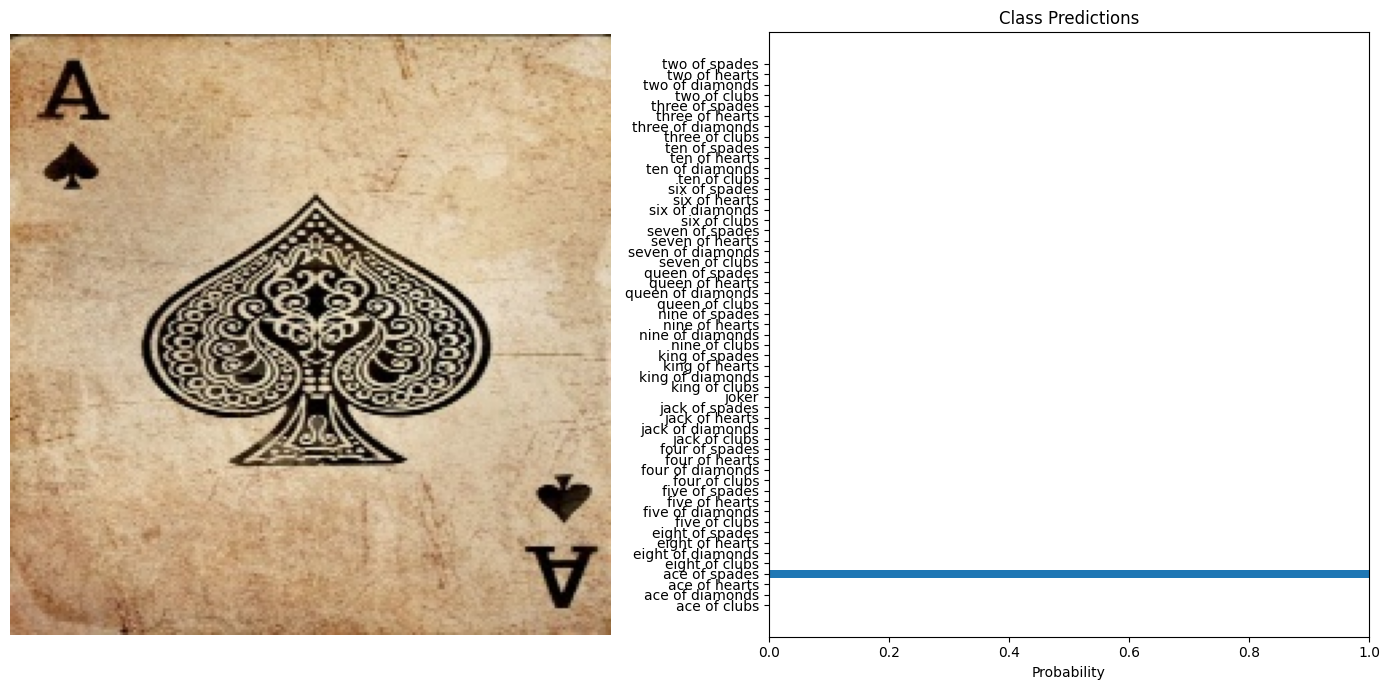

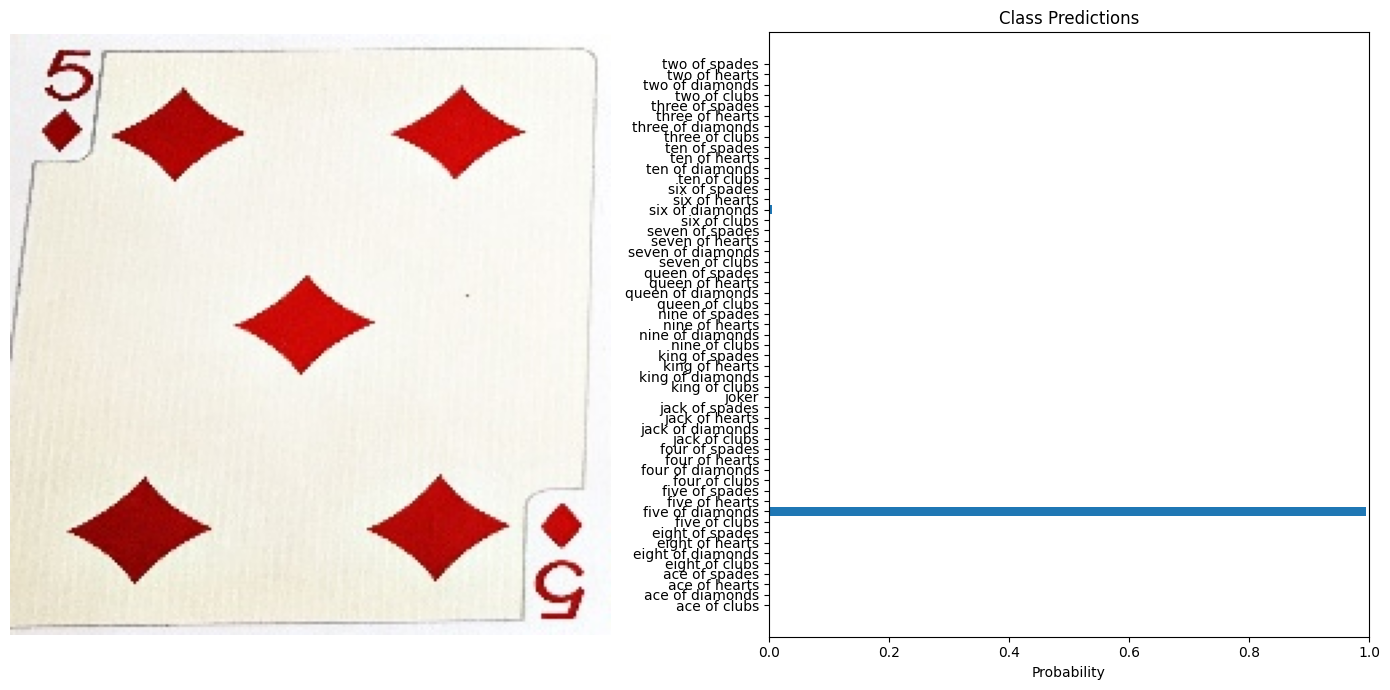

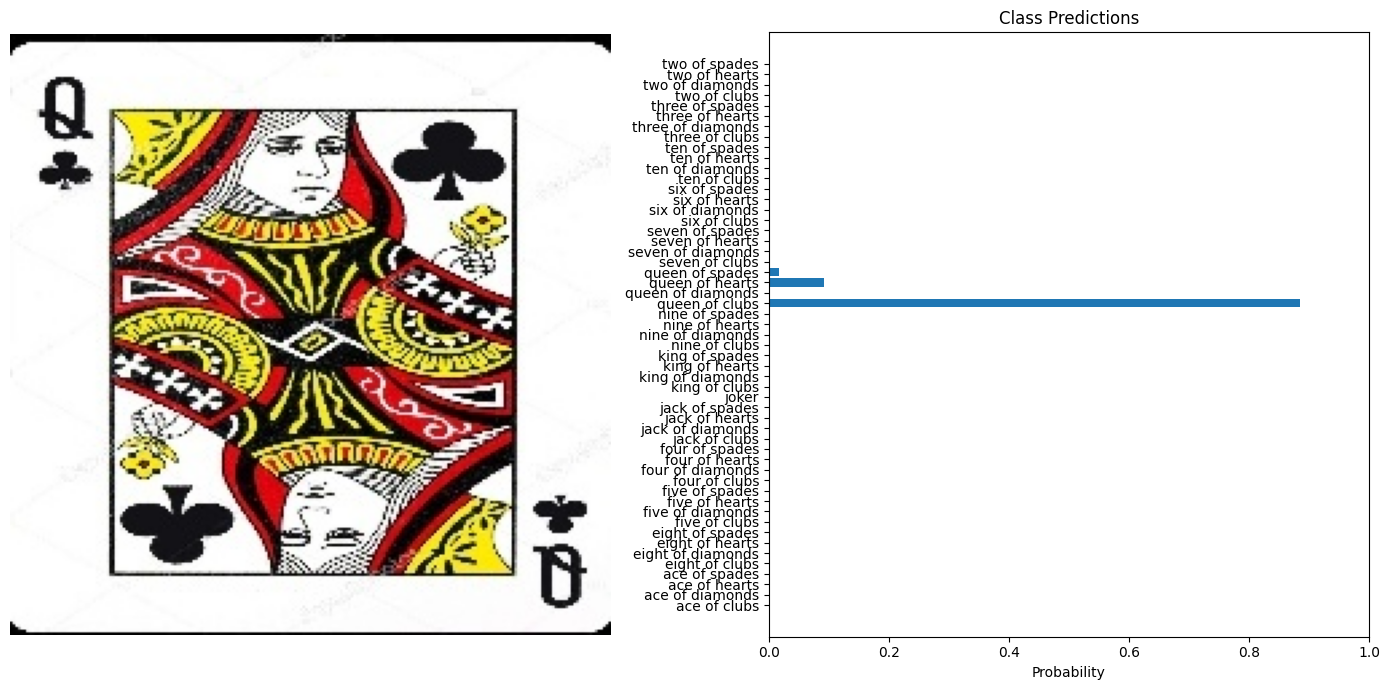

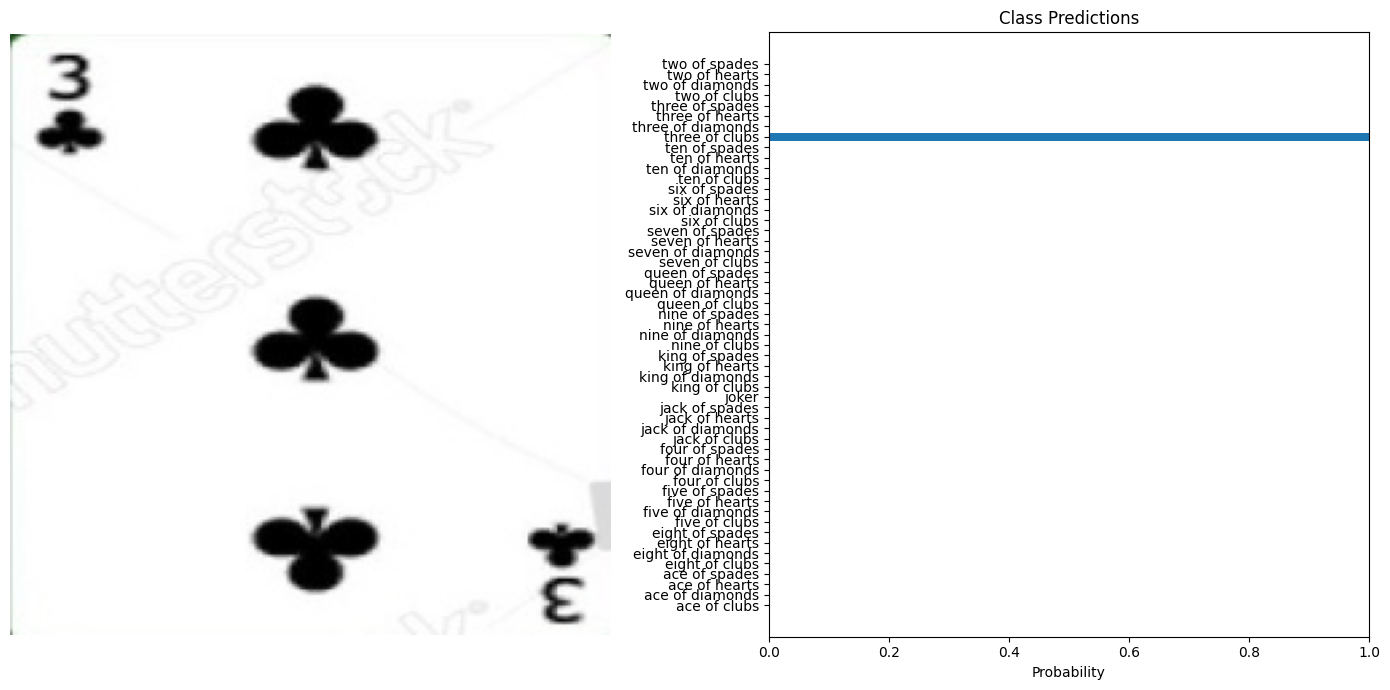

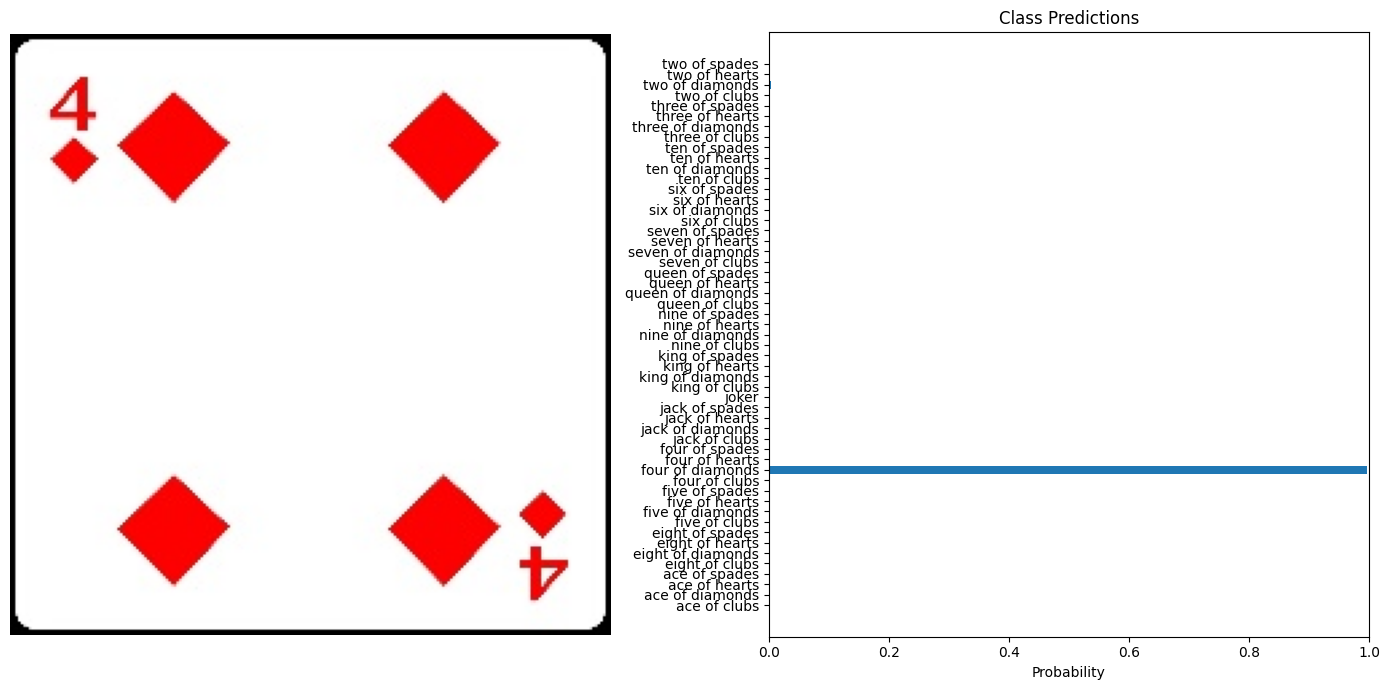

In [119]:
test_images = glob('dataset/test/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes
    visualize_predictions(original_image, probabilities, class_names)